In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, random
from sklearn.metrics import confusion_matrix, classification_report

# Set seeds for reproducibility
tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

In [2]:
# Configuration parameters
# DATASET_DIR =  "/kaggle/input/bcd-new/Dataset"
DATASET_DIR =  "/kaggle/input/bcd-new-augmented/Dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)      # ResNet101 expects 224x224 images
INITIAL_EPOCHS = 100
FINE_TUNE_EPOCHS = 50

In [3]:
# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
print("Classes found:", train_ds.class_names)

Found 11912 files belonging to 2 classes.
Using 9530 files for training.
Found 11912 files belonging to 2 classes.
Using 2382 files for validation.
Classes found: ['Cancer', 'Non-Cancer']


In [4]:
# Calculate class weights from the training dataset
train_class_counts = [0, 0]
for _, labels in train_ds.unbatch():
    train_class_counts[int(labels.numpy())] += 1
total_train = sum(train_class_counts)
class_weights = {i: total_train / (2 * train_class_counts[i]) for i in range(2)}
print("Calculated class weights:", class_weights)

Calculated class weights: {0: 2.9633084577114426, 1: 0.6014895228477657}


In [5]:
# Access the class names from the dataset
class_names = train_ds.class_names

for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

0: Cancer
1: Non-Cancer


In [8]:
# Use MirroredStrategy for distributed training across GPUs
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    base_model = tf.keras.applications.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False
    
    # Input layer
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Added Dense layer with 256 units
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout with 50% probability
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout with 50% probability
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout with 50% probability
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks: ModelCheckpoint and EarlyStopping
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_2.keras',         # File to save the model
        monitor='val_accuracy',              # Monitor validation accuracy
        mode='max',                          # Mode 'max' because we want to maximize accuracy
        save_best_only=True,                 # Only save when validation accuracy improves
        verbose=1
    )
    ## early stop stops training so b4

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet101 (Functional)    │ (None, 7, 7, 2048)     │     42,658,176 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             65 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,223,937 (164.89 MB)

 Trainable params: 565,761 (2.16 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [10]:
# Train the model with callbacks
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=INITIAL_EPOCHS,  
                    class_weight=class_weights,
                    # callbacks=[checkpoint_cb, early_stopping_cb],
                    callbacks=[checkpoint_cb],  # Only ModelCheckpoint callback
                    shuffle=True)

Epoch 1/100
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6305 - loss: 0.7992
Epoch 1: val_accuracy improved from -inf to 0.88581, saving model to best_model_2.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 80s 199ms/step - accuracy: 0.6307 - loss: 0.7987 - val_accuracy: 0.8858 - val_loss: 0.3597
Epoch 2/100
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8148 - loss: 0.4466
Epoch 2: val_accuracy improved from 0.88581 to 0.94123, saving model to best_model_2.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 52s 174ms/step - accuracy: 0.8149 - loss: 0.4464 - val_accuracy: 0.9412 - val_loss: 0.2411
Epoch 3/100
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8809 - loss: 0.3463
Epoch 3: val_accuracy improved from 0.94123 to 0.94542, saving model to best_model_2.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.8810 - loss: 0.3462 - val_accuracy: 0.9454 - val_loss: 0.2145
Epoch 4/100
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9048 - loss: 0.2971
Epoch 4: val_a

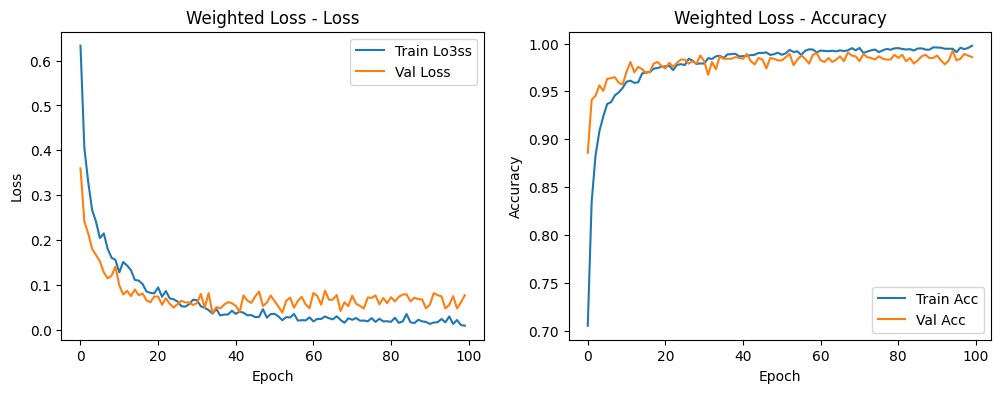

In [11]:
# Plot initial training results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Lo3ss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Weighted Loss - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Weighted Loss - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluation on the validation set
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = np.mean(y_true == y_pred)

When using Keras’s image_dataset_from_directory, the subdirectories are sorted alphabetically and assigned labels in that order. In your case, the two folders are named "Cancer" and "Non-Cancer":

Alphabetical Order: "Cancer" comes before "Non-Cancer."
1. Thus, images in the Cancer folder are assigned label 0.
2. Images in the Non-Cancer folder are assigned label 1.

In [ ]:
from sklearn.metrics import classification_report
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cancer", "Non-Cancer"]))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a display object using the computed confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Non-Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Unfreeze the last 10 layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Train the model (fine-tuning phase) with callbacks
history_ft = model.fit(train_ds, 
                       validation_data=val_ds,
                       epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,  # Total epochs including fine-tuning
                       initial_epoch=INITIAL_EPOCHS,              # Continue from where initial training stopped
                       class_weight=class_weights,                # Handle class imbalance
                       callbacks=[checkpoint_cb],  # Only ModelCheckpoint callback
                       # callbacks=[checkpoint_ft_cb, early_stopping_ft_cb],
                       shuffle=True)  # Shuffle the training data for better generalization

In [ ]:
# Plot fine-tuning results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title("Weighted Loss - Fine-tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_ft.history['accuracy'], label='Train Acc')
plt.plot(history_ft.history['val_accuracy'], label='Val Acc')
plt.title("Weighted Loss - Fine-tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluation on the validation set
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = np.mean(y_true == y_pred)


In [ ]:
from sklearn.metrics import classification_report
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cancer", "Non-Cancer"]))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a display object using the computed confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Non-Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()